In [74]:
import h5py 
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from prophet.plot import plot_plotly,plot_components_plotly
from prophet import Prophet

In [75]:
given_lat= -45
given_lon= -145.824539

In [76]:
date_column = np.empty((0,),dtype='datetime64')
conc_column = np.empty((0,),dtype='float32')

In [77]:
lon_index = int(((np.floor(given_lon/0.25) * 0.25) - (-180))/0.25)
lon_index = 0 if lon_index == 1440 else lon_index
lat_index = int((90 - (np.floor(given_lat/0.25) * 0.25))/0.25)
lat_index = 0 if lat_index == 720 else lat_index

In [78]:
# keep data files here
data_folder = os.listdir('../data/o3-data') 

In [79]:
for data_file in data_folder:
    data = h5py.File(f"../data/o3-data/{data_file}",'r')
    
    dataset = data.require_dataset('/HDFEOS/GRIDS/OMI Column Amount O3/Data Fields/ColumnAmountO3',shape=(720,1440),dtype='float32')
    conc_data = np.array(dataset)
    conc_val = conc_data[lat_index][lon_index]

    attributes = data.require_group('/HDFEOS/ADDITIONAL/FILE_ATTRIBUTES')
    date_str = attributes.attrs.get('EndUTC').decode('utf-8')
    date_val = np.datetime64(date_str)
    date_val

    date_column = np.append(date_column, date_val)
    conc_column = np.append(conc_column,conc_val)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14272\2914765253.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_val = np.datetime64(date_str)


In [80]:
date_column.shape

(1093,)

In [81]:
conc_column.shape

(1093,)

In [82]:
o3_df = pd.DataFrame({'conc' : conc_column}, index=date_column)
o3_df.index = pd.to_datetime(o3_df.index.strftime('%Y-%m-%d'),format='%Y-%m-%d')
o3_df

,conc
2021-04-02,-1.267651e+30
2021-04-03,4.065000e+02
2021-04-04,-1.267651e+30
2021-04-05,3.750000e+02
2021-04-06,3.516000e+02
...,...
2024-03-27,4.378000e+02
2024-03-28,4.334000e+02
2024-03-30,3.044000e+02
2024-03-31,-1.267651e+30


In [83]:
o3_df.describe()

C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,conc
count,1.093000e+03
mean,-4.024472e+29
std,inf
min,-1.267651e+30
25%,-1.267651e+30
50%,3.002000e+02
75%,3.402000e+02
max,4.555000e+02


In [84]:
o3_df[o3_df['conc']<0].value_counts()

conc         
-1.267651e+30    347
Name: count, dtype: int64

In [85]:
filtered_o3_df= o3_df[o3_df['conc']>=0]
filtered_o3_df.conc.mean()

328.98672

In [86]:
o3_df.loc[o3_df['conc']<0,'conc'] =  filtered_o3_df.conc.mean()
o3_df

,conc
2021-04-02,328.986725
2021-04-03,406.500000
2021-04-04,328.986725
2021-04-05,375.000000
2021-04-06,351.600006
...,...
2024-03-27,437.799988
2024-03-28,433.399994
2024-03-30,304.399994
2024-03-31,328.986725


In [87]:
scaler = MinMaxScaler()
o3_df['conc'] = scaler.fit_transform(o3_df[['conc']])
o3_df

,conc
2021-04-02,0.427023
2021-04-03,0.778080
2021-04-04,0.427023
2021-04-05,0.635417
2021-04-06,0.529438
...,...
2024-03-27,0.919837
2024-03-28,0.899909
2024-03-30,0.315670
2024-03-31,0.427023


In [88]:
o3_df['datetime'] = o3_df.index.astype('str')
o3_df = o3_df[['datetime','conc']]
o3_df.reset_index(drop=True, inplace=True)
o3_df.columns=['ds','y']
o3_df

,ds,y
0,2021-04-02,0.427023
1,2021-04-03,0.778080
2,2021-04-04,0.427023
3,2021-04-05,0.635417
4,2021-04-06,0.529438
...,...,...
1088,2024-03-27,0.919837
1089,2024-03-28,0.899909
1090,2024-03-30,0.315670
1091,2024-03-31,0.427023


In [89]:
o3_df.to_csv('../data/o3.csv', index=False)

In [90]:
pro_model = Prophet(interval_width=0.95)

In [91]:
pro_model.fit(o3_df)

19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
future_date = pro_model.make_future_dataframe(periods=60, freq='MS')
future_date.tail()

,ds
1148,2028-12-01
1149,2029-01-01
1150,2029-02-01
1151,2029-03-01
1152,2029-04-01


In [93]:
forecast = pro_model.predict(future_date)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-04-02,0.519479,0.291438,0.771185
1,2021-04-03,0.517021,0.278906,0.762458
2,2021-04-04,0.518211,0.256188,0.766991
3,2021-04-05,0.509779,0.263930,0.756236
4,2021-04-06,0.494729,0.227976,0.734771


C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


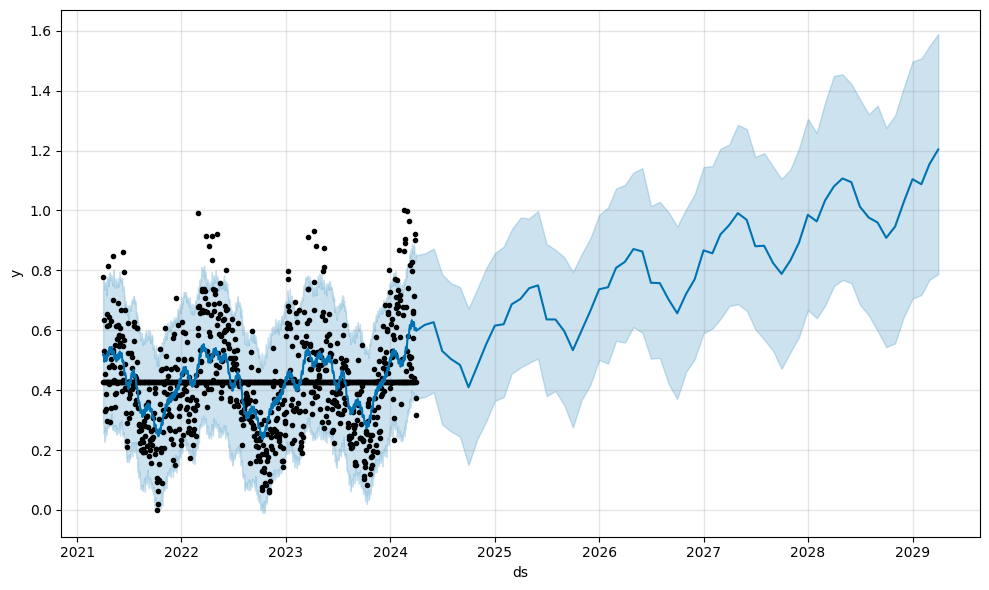

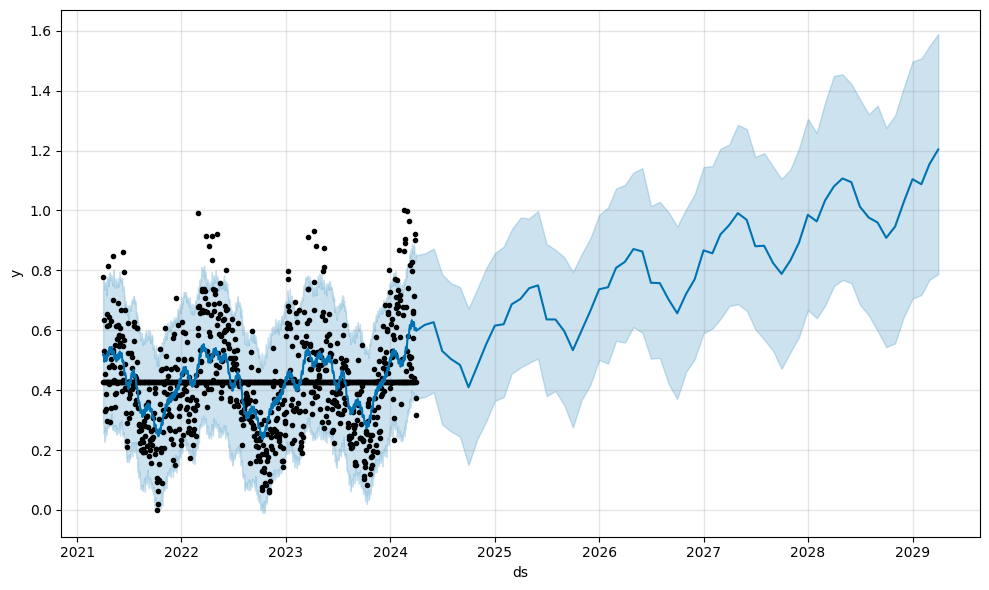

In [94]:
pro_model.plot(forecast, uncertainty=True)

C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is

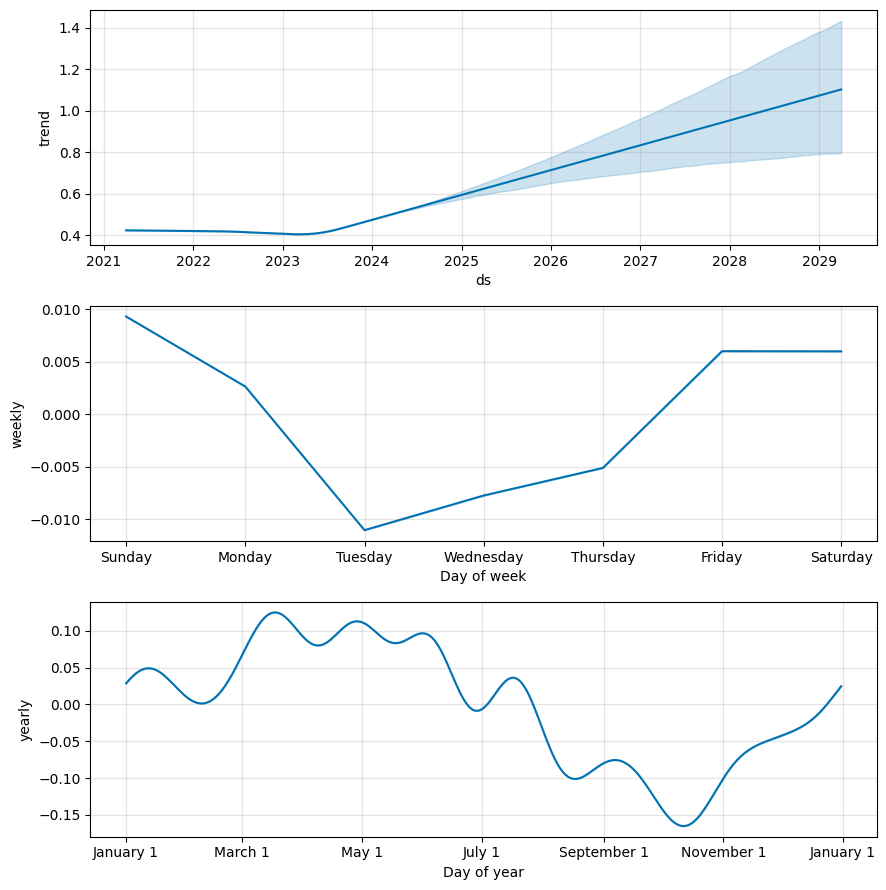

In [95]:
fig1=pro_model.plot_components(forecast)

C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


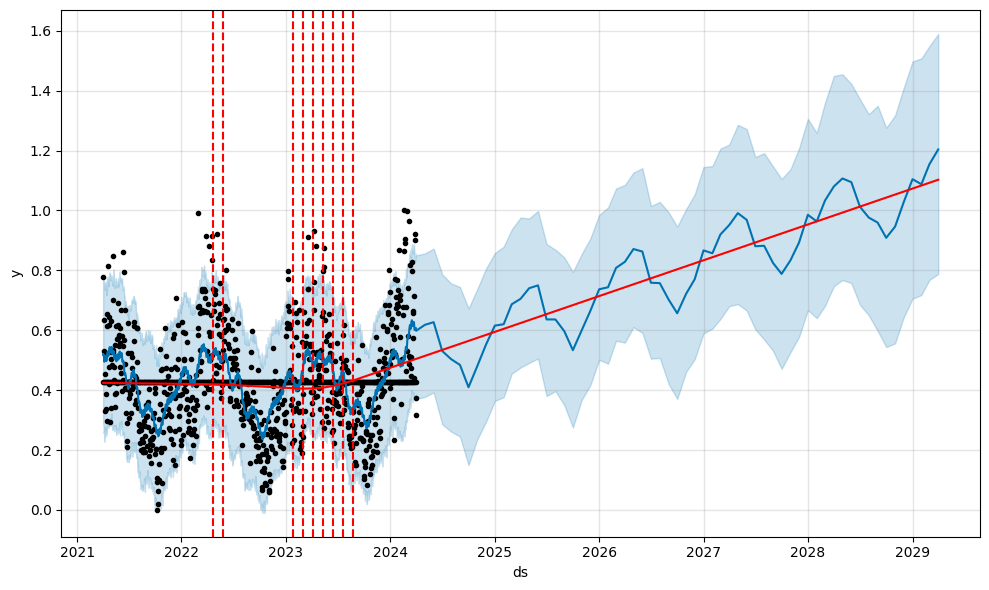

In [96]:
from prophet.plot import add_changepoints_to_plot
fig =pro_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),pro_model,forecast)

In [97]:
pro_model.changepoints

35    2021-05-07
70    2021-06-11
105   2021-07-16
140   2021-08-20
175   2021-09-24
210   2021-10-29
244   2021-12-02
279   2022-01-06
314   2022-02-10
349   2022-03-17
384   2022-04-21
419   2022-05-26
454   2022-06-30
489   2022-08-04
524   2022-09-08
559   2022-10-13
594   2022-11-17
629   2022-12-22
663   2023-01-25
698   2023-03-01
733   2023-04-05
768   2023-05-10
803   2023-06-14
838   2023-07-19
873   2023-08-23
Name: ds, dtype: datetime64[ns]

19:41:34 - cmdstanpy - INFO - Chain [1] start processing
19:41:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\ASUS\Documents\Code\projects\minor project\code\minor-project\venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


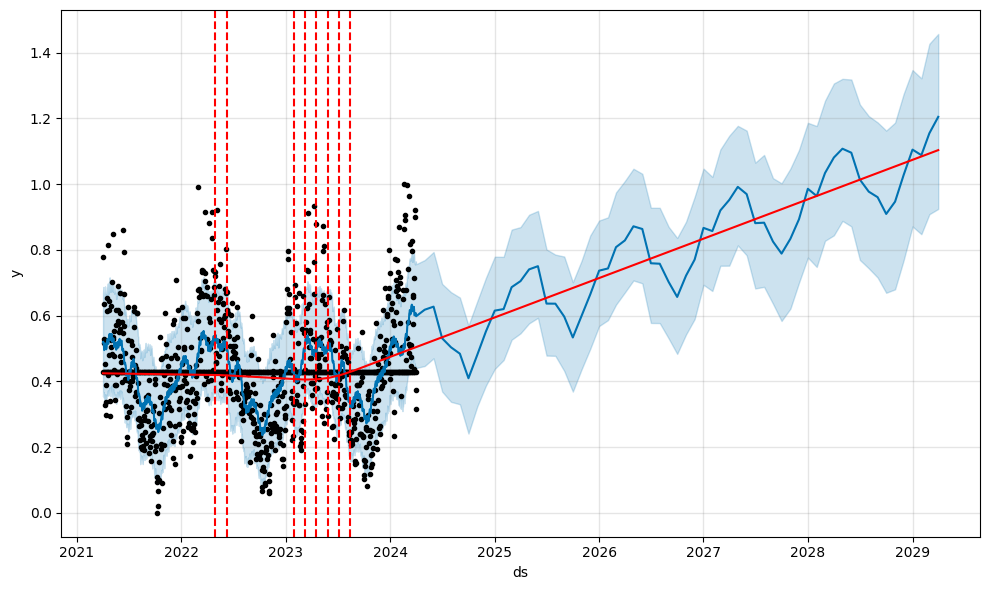

In [98]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(o3_df).predict(future_date)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [100]:
forecast

0       0.519626
1       0.517204
2       0.518424
3       0.510035
4       0.494985
          ...   
1148    1.027753
1149    1.104998
1150    1.088189
1151    1.154784
1152    1.204692
Name: yhat, Length: 1153, dtype: float64